In [1]:
%cd /data/codes/apa/train/

import pandas as pd
import os
from glob import glob
import json
from pandarallel import pandarallel
import random
import re

pandarallel.initialize(nb_workers=8, progress_bar=True)

/data/codes/apa/train
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/10"
# audio_dir = "/data/audio_data/prep_submission_audio/10"

# in_csv_path = "/data/audio_data/pronunciation_scoring_result/merged_info/info_question_type-10_01082022_18092023.csv"
# out_jsonl_path = "data/metadata/raw-jsonl/train-data-type-10.jsonl"

# metadata_path="/data/audio_data/pronunciation_scoring_result/dataset/info_qt_10_trainset.csv"

json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
audio_dir = "/data/audio_data/prep_submission_audio/12"

in_csv_path = "/data/codes/pronunciation-scoring-evaluate/data/raw/train-data-type-12.csv"
out_jsonl_path = "data/metadata/raw-jsonl/train-data-type-12.jsonl"
metadata = pd.read_csv(in_csv_path)
metadata.head(2)

,Unnamed: 0,id,is_deleted,user_id,question_id,question_type,question_content,url,score,fidelity_class,created_at,total_time,word_count
0,113609,3598801,0,102850.0,16681,12,Depressed,https://storage.googleapis.com/materials-eleme...,33.0,RELEVANT,2023-06-29 12:41:33,2.28,1.0
1,310780,3182408,0,61193.0,16681,12,Depressed,https://storage.googleapis.com/materials-eleme...,30.0,RELEVANT,2023-06-05 17:28:06,2.71,1.0


In [3]:
print(metadata.shape)
metadata = metadata[metadata.total_time > 1.0]
metadata = metadata[metadata.total_time < 10.0]
print(metadata.shape)

# metadata = metadata[0:500000]

(81748, 13)
(81647, 13)


<Axes: >

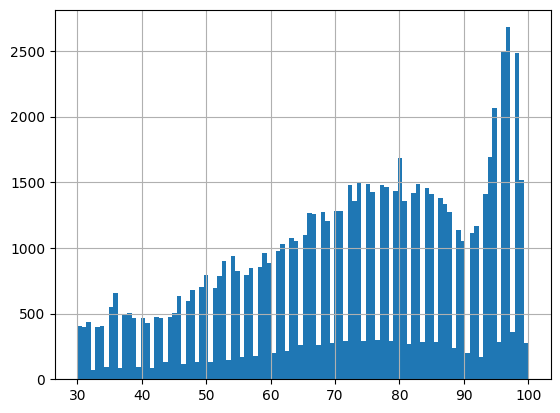

In [4]:
metadata.score.hist(bins=100)

In [5]:
import torchaudio

def is_valid_audio(audio_id):
    abs_path = os.path.join(audio_dir, f'{audio_id}.wav')
    if not os.path.exists(abs_path):
        return False
    try:
        wav, sr = torchaudio.load(abs_path)
        if sr != 16000:
            return False
    except:
        return False
    
    return True

is_exist =  metadata.id.parallel_apply(is_valid_audio)
print(metadata.shape)
metadata = metadata[is_exist]
print(metadata.shape)

(81647, 13)
(81630, 13)


In [6]:
def load_lexicon(path):
    vocab = pd.read_csv(path, sep="\t", names=["word", "arpa"])
    lexicon = {}
    for name, group in vocab.groupby("word"):
        lexicon[name] = set(group["arpa"].tolist())

    return lexicon

lexicon_path = "/data/codes/apa/train/exp/dicts/lexicon"
lexicon = load_lexicon(lexicon_path)

In [9]:
decision2color = {
    "correct": 2,
    "warning":1,
    "error":0
}

def norm_text(text):
    text = re.sub(r"[\,\.\!\?\:\;]", " ", text)
    text = re.sub("\s+", " ", text).strip()
    text = text.upper()

    return text

def is_valid_phoneme(phoneme):
    if phoneme["phoneme_error_arpabet"] != "normal":
        trans = phoneme["phoneme_error_arpabet"].split(" - ")[-1]
        labels = phoneme["phoneme_error_arpabet"].split(" - ")[0]
        if len(labels.split(" ")) >= 2:
            return False
        
        if len(trans.split(" ")) >= 2:
            return False
        
        # if labels in trans:
        #     return False
        
    return True

def is_valid_word(word):
    if norm_text(word["text"]) not in lexicon:
        return False

    # if word["trans_arpabet"] not in lexicon[norm_text(word["text"])]:
    #     return False

    if len(word["phonemes"]) != len(word["trans_arpabet"].split()):
        return False

    return True
            
def parse_metadata_data(json_path):
    try: 
        with open(json_path, "r") as f:
            content = json.load(f)
        id = os.path.basename(json_path).split(".")[0]

        utterances = []
        for raw_utterance in content["utterance"]:
            id = id
            utt_raw_text = raw_utterance["sentence"]
            utt_score = raw_utterance["nativeness_score"]
            
            start_time = None
            end_time = None
            utt_uid = None
            
            utt_text = []
            utt_arpas = []
            utt_trans = [] 
            utt_phone_scores = []
            utt_decisions = []
            utt_word_scores = []
            utt_word_ids = []
            
            ignore = False
            for word_id, word in enumerate(raw_utterance["words"]):
                word["trans_arpabet"] = word["trans_arpabet"].replace("AH0", "AX")
                
                if is_valid_word(word) == False:
                    ignore = True
                    break

                for phoneme in word["phonemes"]:
                    if is_valid_phoneme(phoneme) == False:
                        ignore = True
                        break

                    arpa = phoneme["trans_arpabet"]
                    decision = decision2color[phoneme["decision"]]
                    score = phoneme["nativeness_score"] if phoneme["nativeness_score"] >= 0 else 0
                    tran = phoneme["trans_arpabet"]

                    utt_phone_scores.append(score)
                    utt_word_ids.append(word_id)
                    utt_trans.append(tran)
                    utt_decisions.append(decision)

                wrd_score = word["nativeness_score"]
                wrd_text = norm_text(word["text"])
                wrd_arpa = word["trans_arpabet"].split()
                
                utt_text.append(wrd_text)                
                utt_word_scores.append(wrd_score)
                utt_arpas += wrd_arpa
            

            utterance = {
                "id": id,
                "raw_text": utt_raw_text,
                "text": " ".join(utt_text),
                "utt_id": utt_uid,
                "start_time": start_time,
                "end_time": end_time,
                "arpas": utt_arpas,
                "trans": utt_trans,
                "phone_scores": utt_phone_scores,
                "word_scores": utt_word_scores,
                "decisions": utt_decisions,
                "word_ids": utt_word_ids,
                "utterance_score": utt_score,
            }
            
            if ignore == False:
                utterances.append(utterance)
        
        return utterances
    except:
        return []

extracted_data = metadata.id.parallel_apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))
extracted_data.head()
# metadata.id.head(100).apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))

0    [{'id': '3598801', 'raw_text': 'Depressed', 't...
1    [{'id': '3182408', 'raw_text': 'Depressed', 't...
2    [{'id': '1205156', 'raw_text': 'Depressed', 't...
3    [{'id': '3721019', 'raw_text': 'Depressed', 't...
4    [{'id': '2231077', 'raw_text': 'Depressed', 't...
Name: id, dtype: object

In [10]:
data = extracted_data.explode().reset_index()["id"]
data = pd.DataFrame({"data": data})
print(data.shape)
data.dropna(inplace=True)
data["text"] = data["data"].apply(lambda x: x["text"])
data = data.reset_index()[["data"]]
print(data.shape)
data.head()

(81630, 1)
(81630, 1)


,data
0,"{'id': '3598801', 'raw_text': 'Depressed', 'te..."
1,"{'id': '3182408', 'raw_text': 'Depressed', 'te..."
2,"{'id': '1205156', 'raw_text': 'Depressed', 'te..."
3,"{'id': '3721019', 'raw_text': 'Depressed', 'te..."
4,"{'id': '2231077', 'raw_text': 'Depressed', 'te..."


<Axes: >

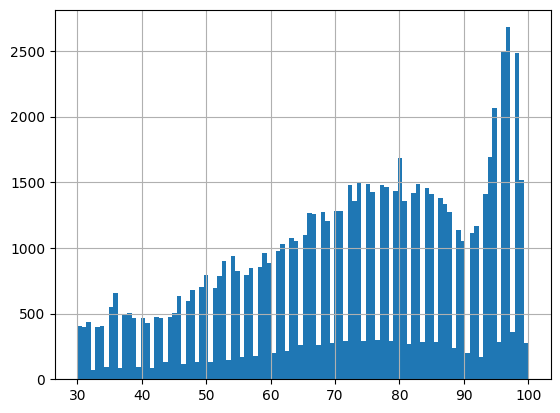

In [11]:
scores = data["data"].apply(lambda x: x["utterance_score"]).to_list()

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

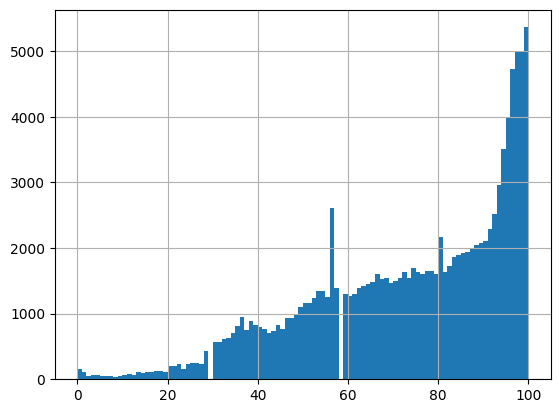

In [12]:
scores = data["data"].apply(lambda x: x["word_scores"]).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

(154326, 1)


<Axes: >

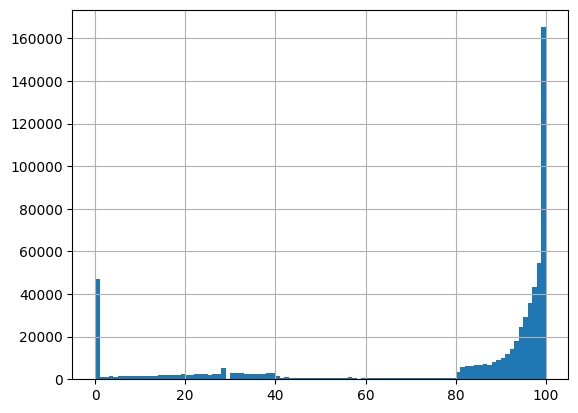

In [13]:
scores = data["data"].apply(lambda x: x["phone_scores"]).to_list()
scores = [score for sample in scores for score in sample]

scores = pd.DataFrame(scores, columns=["score"])
print(scores[scores.score<80].shape)
scores.score.hist(bins=100)

<Axes: >

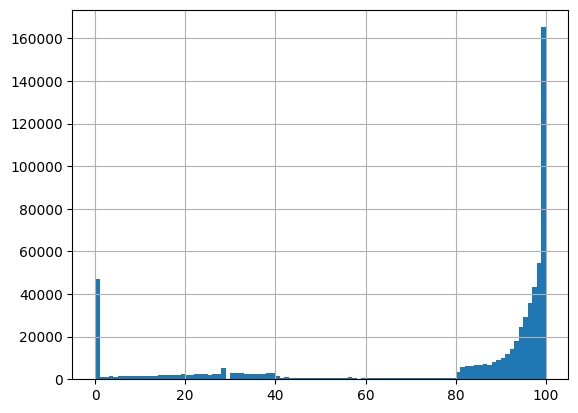

In [14]:
scores = data["data"].apply(lambda x: x["phone_scores"]).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

In [15]:
from tqdm import tqdm
 
extracted_data = data
with open(out_jsonl_path, "w", encoding="utf-8") as f:
    for index in tqdm(extracted_data.index):
        sample = extracted_data.loc[index, "data"]
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

100%|██████████| 81630/81630 [00:00<00:00, 142655.91it/s]
